# Traditional method for Segmentation based on Otsu Thresholding

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.color import rgb2gray
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops
import os
from cellpose import metrics
import shutil

We firstly get images and masks for our training set and testing set.

In [2]:
def getImagesAndSegmentations(folderPath):
    """
    This function is a utility function to retrieve all images and segmentations from a folder.
    Input: folderPath - path to folder containing images and segmentations
    Output: images - list of images, segmentations - list of corresponding segmentations data i.e., seg.npy files
    """
    # retrieve all images and segmentations
    allFiles = os.listdir(folderPath)
    images = []
    segmentations = []
    for imgFile in allFiles:
        # if we have an actual image i.e., ends with .png
        if imgFile.endswith('.png'):
            correspondingSegFile = imgFile.split('.')[0] + '_seg.npy'
            imgFilePath = os.path.join(folderPath, imgFile)
            segFilePath = os.path.join(folderPath, correspondingSegFile)
            images.append(plt.imread(imgFilePath))
            segmentations.append(np.load(segFilePath, allow_pickle=True).item())
            
    return images, segmentations

def getMasks(segmentations):
    """
    This function is a utility function to retrieve masks from segmentation data.
    Input: segmentationData - dictionary containing segmentation data
    Output: masks - list of masks
    """
    masks = []
    for segmentationData in segmentations:
        masks.append(segmentationData['masks'])
    return masks

In [3]:
trainingImages, trainingSegmentations = getImagesAndSegmentations('glialCellsImages/train')
testImages, testSegmentations = getImagesAndSegmentations('glialCellsImages/test')

In [4]:
trainingMasks = getMasks(trainingSegmentations)
testMasks = getMasks(testSegmentations)

An example of an image and its corresponding masks where each pixel is assigned to an ROI.

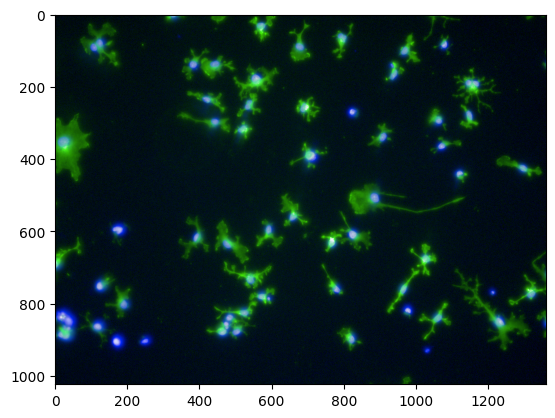

In [5]:
plt.imshow(trainingImages[0])

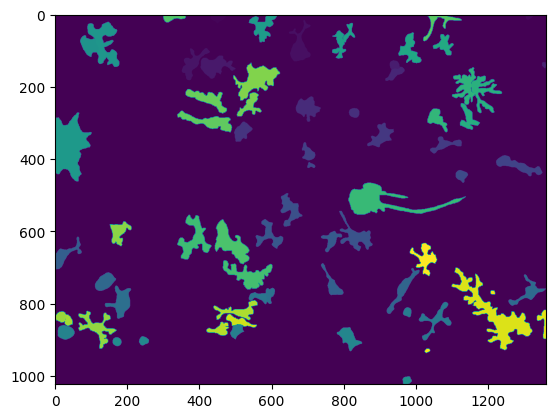

In [6]:
plt.imshow(trainingMasks[0])

Parameters to search over.

In [7]:
parameterGrid = {
    'gaussian_blur_kernel_size': [(3, 3), (5, 5)],
    'otsu_classes': [3, 4, 5, 6],
    'morphological_disk_size_opening': [0, 1, 2],
    'morphological_disk_size_closing': [0, 1, 2],
}

In [8]:
idx = 1
for g in parameterGrid['gaussian_blur_kernel_size']:
    for o in parameterGrid['otsu_classes']:
        for d in parameterGrid['morphological_disk_size_opening']:
            for c in parameterGrid['morphological_disk_size_closing']:
                print(f"{idx}. Guassian Blue Kernel Size {g}, Otsu Classes {o}, Opening Size {d}, Closing Size {c}")
                idx += 1

1. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 0, Closing Size 0
2. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 0, Closing Size 1
3. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 0, Closing Size 2
4. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 1, Closing Size 0
5. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 1, Closing Size 1
6. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 1, Closing Size 2
7. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 2, Closing Size 0
8. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 2, Closing Size 1
9. Guassian Blue Kernel Size (3, 3), Otsu Classes 3, Opening Size 2, Closing Size 2
10. Guassian Blue Kernel Size (3, 3), Otsu Classes 4, Opening Size 0, Closing Size 0
11. Guassian Blue Kernel Size (3, 3), Otsu Classes 4, Opening Size 0, Closing Size 1
12. Guassian Blue Kernel Size (3, 3), Otsu Classes 4, Opening Size 0, Clos

Find the best parameters based on training data.

In [9]:
def getLabelsMask(image, gaussianBlurKernelSize, otsuClasses, morphologicalDiskSizeOpen, morphologicalDiskSizeClose):
    """
    This function is a utility function to get the labels mask for an image using the given parameters.
    Input: image - image for which to get the labels mask, parameters - dictionary containing parameters
    Output: labelsMask - labels mask
    """
    # convert to grayscale
    grayImage = rgb2gray(image)
    
    # apply gaussian blur
    blurredImage = cv2.GaussianBlur(grayImage, gaussianBlurKernelSize, 0)
    
    # apply contrast enhancement
    enhancedImage = cv2.equalizeHist((blurredImage * 255).astype(np.uint8))
    
    # apply otsu thresholding
    thresholds = threshold_multiotsu(enhancedImage, otsuClasses)
    regions = np.digitize(enhancedImage, bins=thresholds)

    # apply morphological operations
    if morphologicalDiskSizeOpen > 0:
        regions = morphology.opening(regions, morphology.disk(morphologicalDiskSizeOpen))
    if morphologicalDiskSizeClose > 0:
        regions = morphology.closing(regions, morphology.disk(morphologicalDiskSizeClose))

    binaryImage = regions > otsuClasses - 2 # 0 background, 1 cells

    # Label the regions
    labelImage = label(binaryImage)

    return labelImage
    

In [16]:
def findBestParamsToExtractCells(trainingImages, trainingMasks, parameterGrid):
    """
    This function is used to cross validate the parameters for the extractCells function.
    Input: trainingImages - list of training images, trainingMasks - list of training masks, 
           parameterGrid - dictionary containing parameter grid
    Output: bestAveragePrecision - best average precision, bestGaussianBlurKernelSize - best gaussian blur kernel size, 
            bestContrastEnhancement - best contrast enhancement, bestOtsuClasses - best otsu classes, 
            bestMorphologicalDiskSizeOpen - best morphological disk size for opening, 
            bestMorphologicalDiskSizeClose - best morphological disk size for closing
    """
    bestAveragePrecision = float('-inf')
    bestParams = {}
    allAveragePrecisions = []

    for gaussianBlurKernelSize in parameterGrid['gaussian_blur_kernel_size']:
        for otsuClasses in parameterGrid['otsu_classes']:
            for morphologicalDiskSizeOpen in parameterGrid['morphological_disk_size_opening']:
                for morphologicalDiskSizeClose in parameterGrid['morphological_disk_size_closing']:
                    predictedMasks = [getLabelsMask(img, gaussianBlurKernelSize, otsuClasses, morphologicalDiskSizeOpen, morphologicalDiskSizeClose) for img in trainingImages]
                    averagePrecision = metrics.average_precision(trainingMasks, predictedMasks, 0.5)[0][0]
                    allAveragePrecisions.append(averagePrecision[0])
                    print(f"Average Precision: {averagePrecision[0]:.8f}, Gaussian Blur Kernel Size: {gaussianBlurKernelSize}, Otsu Classes: {otsuClasses}, Morphological Disk Size Opening: {morphologicalDiskSizeOpen}, Morphological Disk Size Closing: {morphologicalDiskSizeClose}")
                    if averagePrecision[0] >= bestAveragePrecision:
                        bestParams = {
                            'gaussian_blur_kernel_size': gaussianBlurKernelSize,
                            'otsu_classes': otsuClasses,
                            'morphological_disk_size_opening': morphologicalDiskSizeOpen,
                            'morphological_disk_size_closing': morphologicalDiskSizeClose
                        }

    return bestAveragePrecision, bestParams, allAveragePrecisions
                    

In [29]:
bestAveragePrecision, bestParams, allAveragePrecisions = findBestParamsToExtractCells(trainingImages, trainingMasks, parameterGrid)

Average Precision: 0.00068133, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 0, Morphological Disk Size Closing: 0
Average Precision: 0.00062743, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 0, Morphological Disk Size Closing: 1
Average Precision: 0.00081185, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 0, Morphological Disk Size Closing: 2
Average Precision: 0.00331492, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 1, Morphological Disk Size Closing: 0
Average Precision: 0.00373134, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 1, Morphological Disk Size Closing: 1
Average Precision: 0.00565771, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 3, Morphological Disk Size Opening: 1, Morphological Disk Size Closing: 2
Average Precision: 0.01321586, Gaussian Blur Kernel Size: (3, 3), Otsu Class

In [45]:
bestGaussianBlurKernelSize = bestParams['gaussian_blur_kernel_size']
bestOtsuClasses = bestParams['otsu_classes']
bestMorphologicalDiskSizeOpen = bestParams['morphological_disk_size_opening']
bestMorphologicalDiskSizeClose = bestParams['morphological_disk_size_closing']

In [46]:
print('Best Average Precision:', bestAveragePrecision)
print('Best Gaussian Blur Kernel Size:', bestGaussianBlurKernelSize)
print('Best Otsu Classes:', bestOtsuClasses)
print('Best Morphological Disk Size for Opening:', bestMorphologicalDiskSizeOpen)
print('Best Morphological Disk Size for Closing:', bestMorphologicalDiskSizeClose)

Best Average Precision: 0.3592233
Best Gaussian Blur Kernel Size: (5, 5)
Best Otsu Classes: 6
Best Morphological Disk Size for Opening: 2
Best Morphological Disk Size for Closing: 1


Save results in a text file called traditionalSegmentationResults.

In [40]:
idx = 0
outputTextLines = []
for gaussianBlurKernelSize in parameterGrid['gaussian_blur_kernel_size']:
    for otsuClasses in parameterGrid['otsu_classes']:
        for morphologicalDiskSizeOpen in parameterGrid['morphological_disk_size_opening']:
            for morphologicalDiskSizeClose in parameterGrid['morphological_disk_size_closing']:
                outputTextLines.append(f"Average Precision: {allAveragePrecisions[idx]:.8f}, Gaussian Blur Kernel Size: {gaussianBlurKernelSize}, Otsu Classes: {otsuClasses}, Morphological Disk Size Opening: {morphologicalDiskSizeOpen}, Morphological Disk Size Closing: {morphologicalDiskSizeClose}")
                idx += 1

In [42]:
with open('traditionalSegmentationResults.txt', 'w') as f:
    for line in outputTextLines:
        f.write(line + '\n')

We display the top 10 best set of parameters.

In [47]:
indicesSorted = np.argsort(allAveragePrecisions)[::-1]

In [48]:
# top 10 best parameters
for i in range(10):
    print(outputTextLines[indicesSorted[i]])

Average Precision: 0.35922330, Gaussian Blur Kernel Size: (5, 5), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 1
Average Precision: 0.35922330, Gaussian Blur Kernel Size: (5, 5), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 0
Average Precision: 0.35576922, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 0
Average Precision: 0.35576922, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 1
Average Precision: 0.35294120, Gaussian Blur Kernel Size: (5, 5), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 2
Average Precision: 0.34951457, Gaussian Blur Kernel Size: (3, 3), Otsu Classes: 6, Morphological Disk Size Opening: 2, Morphological Disk Size Closing: 2
Average Precision: 0.33644860, Gaussian Blur Kernel Size: (5, 5), Otsu Class

As can be observed from the results the first two set of parameters give the same average precision on the training set, thus we use both set of paramaters to evaluate these parameters in our test set.

In [49]:
bestGaussianBlurKernelSize1 = (5, 5)
bestOtsuClasses1 = 6 
bestMorphologicalDiskSizeOpen1 = 2
bestMorphologicalDiskSizeClose1 = 1

bestGaussianBlurKernelSize2 = (5, 5)
bestOtsuClasses2 = 6
bestMorphologicalDiskSizeOpen2 = 2
bestMorphologicalDiskSizeClose2 = 0

In [50]:
predictedTestMasks1 = [getLabelsMask(img, bestGaussianBlurKernelSize1, bestOtsuClasses1, bestMorphologicalDiskSizeOpen1, bestMorphologicalDiskSizeClose1) for img in testImages]

In [54]:
averageTestPrecision1 = metrics.average_precision(testMasks, predictedTestMasks1, 0.5)[0][0]

In [55]:
print('Average Test Precision (set of parameters 1):', averageTestPrecision1[0])

Average Test Precision (set of parameters 1): 0.2090909


In [56]:
predictedTestMasks2 = [getLabelsMask(img, bestGaussianBlurKernelSize2, bestOtsuClasses2, bestMorphologicalDiskSizeOpen2, bestMorphologicalDiskSizeClose2) for img in testImages]

In [57]:
averageTestPrecision2 = metrics.average_precision(testMasks, predictedTestMasks2, 0.5)[0][0]

In [58]:
print('Average Test Precision (set of parameters 2):', averageTestPrecision2[0])

Average Test Precision (set of parameters 2): 0.20535715


On the test set, we still have the first set of parameters having a better average IOU compared to the other parameters. Thus, we will use those to extract cells.

In [60]:
def extractCells(image, gaussianBlurKernelSize, otsuClasses, morphologicalDiskSizeOpen, morphologicalDiskSizeClose):
    # convert to grayscale
    grayImage = rgb2gray(image)
    
    # apply gaussian blur
    blurredImage = cv2.GaussianBlur(grayImage, gaussianBlurKernelSize, 0)
    
    # apply contrast enhancement
    enhancedImage = cv2.equalizeHist((blurredImage * 255).astype(np.uint8))

    # apply otsu thresholding
    thresholds = threshold_multiotsu(enhancedImage, otsuClasses)
    regions = np.digitize(enhancedImage, bins=thresholds)

    # apply morphological operations
    if morphologicalDiskSizeOpen > 0:
        regions = morphology.opening(regions, morphology.disk(morphologicalDiskSizeOpen))
    if morphologicalDiskSizeClose > 0:
        regions = morphology.closing(regions, morphology.disk(morphologicalDiskSizeClose))

    binaryImage = regions > otsuClasses - 2 # 0 background, 1 cells

    # Label the regions
    labelImage = label(binaryImage)
    regionProps = regionprops(labelImage)

    cells = []
    for prop in regionProps:
        minr, minc, maxr, maxc = prop.bbox
        cell = image[minr:maxr, minc:maxc]
        cells.append(cell)

    return labelImage, cells

We can now save the results by extracting the cell patches using the best parameters found for each image. Note, here, we only extract and save patches for a single test image, but this can be repeated for all available images.

In [61]:
allLabels, allCells = extractCells(testImages[0], bestGaussianBlurKernelSize1, bestOtsuClasses1, bestMorphologicalDiskSizeOpen1, bestMorphologicalDiskSizeClose1)

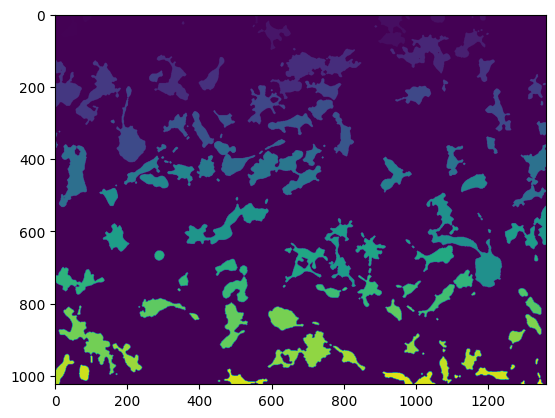

In [62]:
plt.imshow(allLabels)

In [75]:
def getCellPatches(image, masksROI):
    """
    Input: image - image to extract cell patches from, masksROI - masks for the image
    Output: cellPatches - list of cell patches extracted from the image
    """
    cellPatches = []
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)
        contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        roiPatch = image[:, :, 0:3][y:y+h, x:x+w, :].copy()

        cellPatches.append(roiPatch)

    return cellPatches

def getCellPatchesWithNoBackgroundInfo(image, masksROI):
    """
    Input: image - image to extract cell patches from, masksROI - masks for the image
    Output: cellPatches - list of cell patches extracted from the image with no background information
    """
    cellPatches = []
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)
        contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        roiPatch = image[:, :, 0:3][y:y+h, x:x+w, :].copy()

        # black out background
        roiPatch[binMask[y:y+h, x:x+w] == 0] = 0

        cellPatches.append(roiPatch)

    return cellPatches

In [76]:
cellPatches = getCellPatches(testImages[0], allLabels)

In [77]:
cellPatchesWithNoBackgroundInfo = getCellPatchesWithNoBackgroundInfo(testImages[0], allLabels)

In [79]:
def saveAllPatches(folderName, rgbAllPatches):
    """
    Input: folderName - name of folder to save patches to, rgbAllPatches - list of all cell patches
    Output: None
    """
    if os.path.exists(folderName):
        shutil.rmtree(folderName)
    os.mkdir(folderName)
    for i in range(len(rgbAllPatches)):
        # scale image from 0-1 to 0-255
        scaledImage = (rgbAllPatches[i] * 255).astype(np.uint8)
        # convert from 0-255 to BGR
        bgrImage = cv2.cvtColor(scaledImage, cv2.COLOR_RGB2BGR)
        # save image
        imgPath = os.path.join(folderName, str(i) + '.png')
        cv2.imwrite(imgPath, bgrImage)

In [80]:
saveAllPatches('allCellPatchesTradTest1', cellPatches)

In [81]:
saveAllPatches('allCellPatchesWithNoBackgroundInfoTradTest1', cellPatchesWithNoBackgroundInfo)